In [1]:
from transformers import AutoTokenizer
import torch
import torch.nn as nn
import torch.nn.functional as F

class BLSTMSpeechScoring(nn.Module):
    def __init__(self, input_size=768, hidden_size=128, num_layers=1, output_size=1, embedding_dim=64, vocab_size=4000):
        super(BLSTMSpeechScoring, self).__init__()

        # 聲學特徵的 BLSTM
        self.acoustic_blstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                    num_layers=num_layers, batch_first=True, bidirectional=True)

        # 語言特徵（字符）的 BLSTM
        self.linguistic_blstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size,
                     num_layers=num_layers, batch_first=True, bidirectional=True)

        # 字符的嵌入層
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

        # 處理 BLSTM 輸出的線性層，以匹配維度
        self.acoustic_linear = nn.Linear(hidden_size * 2, hidden_size)
        self.linguistic_linear = nn.Linear(hidden_size * 2, hidden_size)

        # 串接後的最終線性層
        self.final_linear = nn.Linear(hidden_size * 2, output_size)

    def forward(self, acoustic_input, linguistic_input):
        # 聲學輸入通過 BLSTM
        acoustic_output, _ = self.acoustic_blstm(acoustic_input)

        # 將語言輸入嵌入並通過 BLSTM
        embedded_chars = self.embedding(linguistic_input)
        linguistic_output, _ = self.linguistic_blstm(embedded_chars)

        # 線性層確保維度匹配
        acoustic_features = self.acoustic_linear(acoustic_output)
        linguistic_features = self.linguistic_linear(linguistic_output)

        # 對兩輸出進行全局平均池化（GAP）
        gap_acoustic = torch.mean(acoustic_features, dim=1)
        gap_linguistic = torch.mean(linguistic_features, dim=1)

        # 確保在串接之前批量大小相同，怕音檔和文字的數量不對，取完整的
        if gap_acoustic.size(0) != gap_linguistic.size(0):
            min_batch_size = min(gap_acoustic.size(0), gap_linguistic.size(0))
            gap_acoustic = gap_acoustic[:min_batch_size, :]
            gap_linguistic = gap_linguistic[:min_batch_size, :]

        # 串接特徵並最終評分
        concatenated_features = torch.cat((gap_acoustic, gap_linguistic), dim=1)
        concatenated_features = F.relu(concatenated_features)
        score = self.final_linear(concatenated_features)

        return score


# Trainer

In [44]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
jugde = 0.65

class Trainer:
    def __init__(self, model, tokenizer, loss_fn):
        self.model = model
        self.tokenizer = tokenizer
        self.loss_fn = loss_fn
        
    def evaluate(self, eval_loader):
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for acoustic_input, text, y_batch in eval_loader:
                
                acoustic_input = acoustic_input.to(device)
                y_batch = y_batch.to(device)
                
                encoded_input = self.tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=100)
                linguistic_input = encoded_input['input_ids'].to(device)
                outputs = self.model(acoustic_input, linguistic_input)

                loss = self.loss_fn(outputs, y_batch)
                additional_loss  = 0 * abs((torch.where(outputs > jugde, torch.tensor(1.0), torch.tensor(0.0))) - y_batch)
                additional_loss = additional_loss.mean()
                loss = loss + additional_loss
                total_loss += loss.item()
            avg_loss = total_loss / len(eval_loader)
            print(f"Evaluation Loss: {avg_loss}")

    def pred(self, acoustic_input, text):
        self.model.eval()
        with torch.no_grad():
            
            acoustic_input = acoustic_input.to(device)
            
            encoded_input = self.tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=100)
            linguistic_input = encoded_input['input_ids'].to(device)
            outputs = self.model(acoustic_input, linguistic_input)
        return outputs

    def pred_list_threshold(self, eval_loader):
        self.model.eval()
        all_predictions = []
        all_true_labels = []

        with torch.no_grad():
            for acoustic_input, text, y_batch in eval_loader:
                outputs = self.pred(acoustic_input, text)
                predicted = torch.where(outputs > jugde, torch.tensor(1.0), torch.tensor(0.0))
                all_predictions.extend(predicted.view(-1).tolist())
                all_true_labels.extend(y_batch.view(-1).tolist())
        return all_predictions, all_true_labels
    
    def pred_list(self, eval_loader):
        self.model.eval()
        all_scores = []  # Change to store the raw scores
        all_true_labels = []

        with torch.no_grad():
            for acoustic_input, text, y_batch in eval_loader:
                outputs = self.pred(acoustic_input, text)
                all_scores.extend(outputs.view(-1).tolist())  # Store raw scores
                all_true_labels.extend(y_batch.view(-1).tolist())
        return all_scores, all_true_labels

    
    def confusion_matrix(self, eval_loader):
        all_predictions, all_true_labels = self.pred_list_threshold(eval_loader)

        cm = confusion_matrix(all_true_labels, all_predictions)
        print("Confusion Matrix:\n", cm)

        tn, fp, fn, tp = cm.ravel()
        print(f"True Negatives: {tn}")
        print(f"False Positives: {fp}")
        print(f"False Negatives: {fn}")
        print(f"True Positives: {tp}", end=f"\n----------------\n")

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (fp + tn) if (fp + tn) > 0 else 0
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"Specificity: {specificity:.2f}")

        accuracy = (tp + tn) / (tp + tn + fp + fn)
        print(f"Accuracy: {accuracy:.2f}")

        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        print(f"F1 Score: {f1:.2f}")
        return precision, recall, specificity, accuracy, f1

# 怎麼輸入進 Hubert？
## 將音檔先全部輸入進 Hubert得到特徵，再加入文字做成data_loader？

In [3]:
from transformers import HubertForCTC, Wav2Vec2Processor

processor = Wav2Vec2Processor.from_pretrained('TKU410410103/hubert-base-japanese-asr')

hubert = HubertForCTC.from_pretrained('TKU410410103/hubert-base-japanese-asr')
# hubert = HubertForCTC.from_pretrained('../HubertForCTC/local_dataset/local_ASR/checkpoint-450')
hubert.config.output_hidden_states=True
# [batch_size, sequence_length, feature]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# hubert.to(device)

In [5]:
import torch
with torch.no_grad():
    output = hubert(torch.rand(1, 16000))
len(output.hidden_states)

13

# 做 dataframe

# (預計) 使用語音辨識產生 text_table

In [6]:
# !unzip -q ./A_class.zip -d ./
# !unzip -q ./B_class.zip -d ./
# !unzip -q ./C_class.zip -d ./
# !unzip -q ./augmented_audio.zip -d ./

In [7]:
import pandas as pd
import numpy as np

def make_score_table(file_path):
    df_full = pd.read_excel(file_path)
    df_reordered = df_full.set_index('Unnamed: 0').reset_index()
    score_table = df_reordered.replace({'〇': float(1), 'O': float(1), '✖': float(0), 'X': float(0), '×': float(0)})
    score_table.rename(columns={'Unnamed: 0': 'Text'}, inplace=True)
    return score_table


In [8]:
# file_path = '/content/判定のコピー.xlsx'

A_score_table = make_score_table(file_path='./語音辨識判定.xlsx')
B_score_table = make_score_table(file_path='./判定のコピー.xlsx')
C_score_table = make_score_table(file_path='./語音辨識判定(SHIH).xlsx')

# 查表，有分數再加入 dataframe

In [9]:
# 原本 dataset

df = pd.DataFrame(columns=['audio_path', 'text', 'score'])

rows = []

for class_name, score_table in zip(['A', 'B', 'C'], [A_score_table, B_score_table, C_score_table]):
    for person in range(10-2):
        for index in range(23):
            score = score_table.loc[index, f'音檔{person+1}']
            text = score_table.loc[index, 'Text']
            if pd.isna(score):
                continue
            audio_path = f'./{class_name}_class/{class_name}_class_audio_{person+1}/{text}.mp3'
            rows.append({'audio_path': audio_path, 'text': text, 'score': score})

df = pd.DataFrame(rows)

print(df)


                              audio_path   text  score
0      ./A_class/A_class_audio_1/わたし.mp3    わたし    1.0
1    ./A_class/A_class_audio_1/わたしたち.mp3  わたしたち    1.0
2      ./A_class/A_class_audio_1/あなた.mp3    あなた    1.0
3     ./A_class/A_class_audio_1/あのひと.mp3   あのひと    0.0
4     ./A_class/A_class_audio_1/あのかた.mp3   あのかた    1.0
..                                   ...    ...    ...
536     ./C_class/C_class_audio_8/だれ.mp3     だれ    1.0
537    ./C_class/C_class_audio_8/どなた.mp3    どなた    1.0
538    ./C_class/C_class_audio_8/～さい.mp3    ～さい    1.0
539   ./C_class/C_class_audio_8/なんさい.mp3   なんさい    1.0
540   ./C_class/C_class_audio_8/おいくつ.mp3   おいくつ    1.0

[541 rows x 3 columns]


In [10]:
import os

def list_files_in_directory(directory):
    files = os.listdir(directory)
    
    file_list = []
    
    for file in files:
        filepath = os.path.join(directory, file)
        if os.path.isfile(filepath):
            file_list.append(os.path.splitext(file)[0])
    
    return file_list

In [11]:
# 錯誤集的資料增量

augmented_df = pd.DataFrame(columns=['audio_path', 'text', 'score'])

rows = []

for class_name, score_table in zip(['A', 'B', 'C'], [A_score_table, B_score_table, C_score_table]):
    for person in range(10-2):
        directory_path = f'./augmented_audio/{class_name}_class/{class_name}_class_audio_{person+1}'
        file_names = list_files_in_directory(directory_path)
        for index in range(len(file_names)):
            score = 0.0
            text = file_names[index]
            if pd.isna(score):
                continue
            audio_path = f'./augmented_audio/{class_name}_class/{class_name}_class_audio_{person+1}/{text}.mp3'
            rows.append({'audio_path': audio_path, 'text': text, 'score': score})

augmented_df = pd.DataFrame(rows)

print(augmented_df)


                                           audio_path    text  score
0   ./augmented_audio/A_class/A_class_audio_1/きょうし...    きょうし    0.0
1   ./augmented_audio/A_class/A_class_audio_1/かいしゃ...  かいしゃいん    0.0
2   ./augmented_audio/A_class/A_class_audio_1/あのひと...    あのひと    0.0
3   ./augmented_audio/A_class/A_class_audio_1/エンジニ...   エンジニア    0.0
4   ./augmented_audio/A_class/A_class_audio_2/あのかた...    あのかた    0.0
..                                                ...     ...    ...
84  ./augmented_audio/C_class/C_class_audio_8/だいがく...    だいがく    0.0
85  ./augmented_audio/C_class/C_class_audio_8/きょうし...    きょうし    0.0
86  ./augmented_audio/C_class/C_class_audio_8/せんせい...    せんせい    0.0
87  ./augmented_audio/C_class/C_class_audio_8/みなさん...    みなさん    0.0
88  ./augmented_audio/C_class/C_class_audio_8/あのひと...    あのひと    0.0

[89 rows x 3 columns]


In [12]:
# 從來沒參與過的dataset (A, C班的第9, 10人)

unknown_df = pd.DataFrame(columns=['audio_path', 'text', 'score'])

rows = []

for class_name, score_table in zip(['A', 'C'], [A_score_table, C_score_table]):
    for person in range(8, 10):
        for index in range(23):
            score = score_table.loc[index, f'音檔{person+1}']
            text = score_table.loc[index, 'Text']
            if pd.isna(score):
                continue
            audio_path = f'./{class_name}_class/{class_name}_class_audio_{person+1}/{text}.mp3'
            rows.append({'audio_path': audio_path, 'text': text, 'score': score})

unknown_df = pd.DataFrame(rows)

print(unknown_df)


                             audio_path   text  score
0     ./A_class/A_class_audio_9/わたし.mp3    わたし    1.0
1   ./A_class/A_class_audio_9/わたしたち.mp3  わたしたち    1.0
2     ./A_class/A_class_audio_9/あなた.mp3    あなた    1.0
3    ./A_class/A_class_audio_9/あのひと.mp3   あのひと    0.0
4    ./A_class/A_class_audio_9/あのかた.mp3   あのかた    1.0
..                                  ...    ...    ...
82    ./C_class/C_class_audio_10/だれ.mp3     だれ    1.0
83   ./C_class/C_class_audio_10/どなた.mp3    どなた    1.0
84   ./C_class/C_class_audio_10/～さい.mp3    ～さい    1.0
85  ./C_class/C_class_audio_10/なんさい.mp3   なんさい    1.0
86  ./C_class/C_class_audio_10/おいくつ.mp3   おいくつ    1.0

[87 rows x 3 columns]


In [13]:
unknown_augmented_df = pd.DataFrame(columns=['audio_path', 'text', 'score'])

rows = []

for class_name, score_table in zip(['A', 'C'], [A_score_table, C_score_table]):
    for person in range(8, 10):
        directory_path = f'./augmented_audio/{class_name}_class/{class_name}_class_audio_{person+1}'
        file_names = list_files_in_directory(directory_path)
        for index in range(len(file_names)):
            score = 0.0
            text = file_names[index]
            if pd.isna(score):
                continue
            audio_path = f'./augmented_audio/{class_name}_class/{class_name}_class_audio_{person+1}/{text}.mp3'
            rows.append({'audio_path': audio_path, 'text': text, 'score': score})

unknown_augmented_df = pd.DataFrame(rows)

print(unknown_augmented_df)

                                          audio_path   text  score
0  ./augmented_audio/A_class/A_class_audio_9/しゃいん...   しゃいん    0.0
1  ./augmented_audio/A_class/A_class_audio_9/あのひと...   あのひと    0.0
2  ./augmented_audio/A_class/A_class_audio_10/いしゃ...    いしゃ    0.0
3  ./augmented_audio/A_class/A_class_audio_10/あのひ...   あのひと    0.0
4  ./augmented_audio/A_class/A_class_audio_10/エンジ...  エンジニア    0.0
5  ./augmented_audio/C_class/C_class_audio_9/おいくつ...   おいくつ    0.0
6  ./augmented_audio/C_class/C_class_audio_9/エンジニ...  エンジニア    0.0
7  ./augmented_audio/C_class/C_class_audio_10/きょう...   きょうし    0.0
8  ./augmented_audio/C_class/C_class_audio_10/あのひ...   あのひと    0.0
9  ./augmented_audio/C_class/C_class_audio_10/エンジ...  エンジニア    0.0


In [14]:
combined_df = pd.concat([df, augmented_df], ignore_index=True)
unknown_df = pd.concat([unknown_df, unknown_augmented_df], ignore_index=True)

# 將音檔做處理(採樣率、單聲道)

In [15]:
import torchaudio

def process_waveforms(batch):

    waveform, sample_rate = torchaudio.load(batch['audio_path'])

    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)

    # 如果 waveform 是雙聲道，需要轉單聲道。給 4GE用
    if waveform.size(0) > 1:
        waveform = waveform.mean(dim=0)

    # 讓 waveform的維度正確
    if waveform.ndim > 1:
        waveform = waveform.squeeze()

    batch["speech_array"] = waveform

    return batch


# 送入 Hubert得到特徵

In [16]:
def get_acoustic_feature(batch):
    with torch.no_grad():
        processed_audios = processor(batch,
                        sampling_rate=16000,
                        return_tensors="pt",
                        padding=True,
                        truncation=True,
                        max_length=160000)
        outputs = hubert(**processed_audios)

    # all layers
    transformer_hidden_states = outputs.hidden_states[:]

    # Stack transformer hidden states to have a new dimension for layers
    stacked_hidden_states = torch.stack(transformer_hidden_states)

    # Average across layers dimension (0) while keeping sequence_length
    overall_avg_hidden_state = torch.mean(stacked_hidden_states, dim=0)

    return overall_avg_hidden_state # [batch_size, sequence_length, featrues]


# 使用自定義 dataset後包成 loader

In [17]:
from torch.utils.data import Dataset

class AudioFeatureDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        audio_data = self.dataset[idx]
        # speech_array_tensor = torch.tensor(audio_data['speech_array'], dtype=torch.float).to(device)
        # print(type(audio_data['speech_array'])) # list
        feature = get_acoustic_feature(audio_data['speech_array'])

        text = audio_data['text']
        score = audio_data['score']

        return feature, text, score


In [18]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from datasets import Dataset
import torch.nn.functional as F


def dynamic_padding(batch):
    acoustic_feature, text, score_label = zip(*batch)

    max_len = max([feature.shape[1] for feature in acoustic_feature])

    # Pad each sequence to have the same length
    padded_features = []
    for feature in acoustic_feature:
        pad_amount = max_len - feature.shape[1]

        padded_feature = F.pad(feature, (0, 0, 0, pad_amount), mode='constant', value=0)
        padded_features.append(padded_feature)

    padded_features = torch.stack(padded_features, dim=0)
    # print((padded_features).size())
    # 張量在堆疊後是 4D ([batch_size, 1, seq_len, input_size])，
    # squeeze(1) 來移除大小為 1 的維度(第二維)，以確保輸出是 3D 張量
    padded_features = padded_features.squeeze(1)

    score_label = torch.tensor(score_label, dtype=torch.float)
    score_label = score_label.unsqueeze(-1)
    return padded_features, text, score_label


def make_dataloader(df, batch_size, collate_fn=dynamic_padding):
    audio_path = Dataset.from_pandas(df)
    df = audio_path.map(process_waveforms, remove_columns=['audio_path'])

    dataset = AudioFeatureDataset(df) # should be (tensor(0), text[0], score[0])
    print(df)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    return loader


In [19]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(combined_df, test_size=0.2, random_state=42)
batch_size = 4

train_loader = make_dataloader(df=df_train, batch_size=batch_size)
eval_loader = make_dataloader(df=df_test, batch_size=batch_size)
unknown_loader = make_dataloader(df=unknown_df, batch_size=batch_size)

Map:   0%|          | 0/504 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'score', '__index_level_0__', 'speech_array'],
    num_rows: 504
})


Map:   0%|          | 0/126 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'score', '__index_level_0__', 'speech_array'],
    num_rows: 126
})


Map:   0%|          | 0/97 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'score', 'speech_array'],
    num_rows: 97
})


In [20]:
print('train set: ', (df_train['score']==1).sum(), (df_train['score']==0).sum())
print('test set: ', (df_test['score']==1).sum(), (df_test['score']==0).sum())
print('unknown set: ', (unknown_df['score']==1).sum(), (unknown_df['score']==0).sum())

train set:  366 138
test set:  86 40
unknown set:  77 20


# 放進 BLSTM

In [45]:
tokenizer = AutoTokenizer.from_pretrained("cl-tohoku/bert-base-japanese-char")
blstm = BLSTMSpeechScoring().to(device)
model_save_path = "../demo/BLSTMSpeechScoring_0410.pth"
blstm.load_state_dict(torch.load(model_save_path))
loss_fn = nn.MSELoss()
blstm.eval()
trainer = Trainer(blstm, tokenizer, loss_fn)

In [46]:
precision, recall, specificity, accuracy, f1 = trainer.confusion_matrix(eval_loader=eval_loader)
# True Negatives: 預測 Negative，預測結果正確

Confusion Matrix:
 [[33  7]
 [ 8 78]]
True Negatives: 33
False Positives: 7
False Negatives: 8
True Positives: 78
----------------
Precision: 0.92
Recall: 0.91
Specificity: 0.82
Accuracy: 0.88
F1 Score: 0.91


In [47]:
precision, recall, specificity, accuracy, f1 = trainer.confusion_matrix(eval_loader=unknown_loader)

Confusion Matrix:
 [[14  6]
 [ 9 68]]
True Negatives: 14
False Positives: 6
False Negatives: 9
True Positives: 68
----------------
Precision: 0.92
Recall: 0.88
Specificity: 0.70
Accuracy: 0.85
F1 Score: 0.90


In [48]:
# all_df = pd.concat([combined_df, unknown_df], ignore_index=True)
eval_df = pd.concat([df_test, unknown_df], ignore_index=True)

data_loader = make_dataloader(df=eval_df, batch_size=batch_size)

precision, recall, specificity, accuracy, f1 = trainer.confusion_matrix(eval_loader=data_loader)


Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'score', 'speech_array'],
    num_rows: 223
})
Confusion Matrix:
 [[ 47  13]
 [ 16 147]]
True Negatives: 47
False Positives: 13
False Negatives: 16
True Positives: 147
----------------
Precision: 0.92
Recall: 0.90
Specificity: 0.78
Accuracy: 0.87
F1 Score: 0.91


In [25]:
# 未做資料增量
# Confusion Matrix:
#  [[13  8]
#  [ 8 26]]
# True Negatives: 13
# False Positives: 8
# False Negatives: 8
# True Positives: 26
# ----------------
# Precision: 0.76
# Recall: 0.76
# Specificity: 0.62
# Accuracy: 0.71
# F1 Score: 0.76

# 資料增量後 [-1.3, -1.3] [0.7, 1.3]
# Confusion Matrix:
#  [[35  5]
#  [10 76]]
# True Negatives: 35
# False Positives: 5
# False Negatives: 10
# True Positives: 76
# ----------------
# Precision: 0.94
# Recall: 0.88
# Specificity: 0.88
# Accuracy: 0.88
# F1 Score: 0.91

In [26]:
acoustic_input, text, y_batch = next(iter(eval_loader))
print(trainer.pred(acoustic_input, text)) # 在做loss計算之前預測的分數都一樣，練太少或是長度太短？ random seed
text, y_batch

tensor([[0.7500],
        [0.4295],
        [0.9730],
        [0.9692]], device='cuda:0')


(('だれ', 'だいがく', 'みなさん', 'せんせい'),
 tensor([[1.],
         [0.],
         [1.],
         [1.]]))

# 繪圖，使用相同模型，judge = 0.65 下，模型表現視覺化

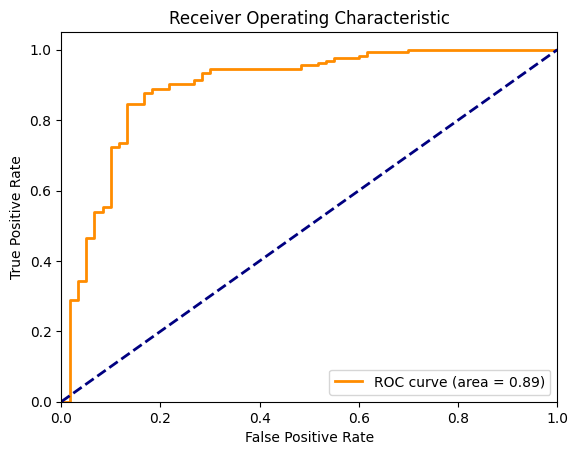

0.894478527607362

In [49]:
 def plot_roc_curve(eval_loader):
        all_predictions, all_true_labels = trainer.pred_list(eval_loader)

        # Calculate ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(all_true_labels, all_predictions)
        roc_auc = auc(fpr, tpr)

        # Plotting ROC Curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
        return roc_auc
plot_roc_curve(eval_loader=data_loader)

In [ ]:
from sklearn.metrics import roc_curve

def plot_precision_recall_vs_threshold(all_true_labels, all_scores):
    plt.figure(figsize=(12, 4))
    plt.title("Precision, Recall, and Specificity Scores as a function of the decision threshold")

    precisions, recalls, thresholds = precision_recall_curve(all_true_labels, all_scores)
    fpr, tpr, thresholds_roc = roc_curve(all_true_labels, all_scores)
    specificity = 1 - fpr

    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, 2*(precisions[:-1]*recalls[:-1])/(precisions[:-1]+recalls[:-1]), "r-", label="F1 Score")
    plt.plot(thresholds_roc, specificity, "y--", label="Specificity")

    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.xlim([0, 1])
    plt.xticks(np.arange(0, 1.05, 0.05))
    plt.show()

all_scores, all_true_labels = trainer.pred_list(eval_loader=data_loader)
plot_precision_recall_vs_threshold(all_true_labels, all_scores)

Map:   0%|          | 0/727 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'score', 'speech_array'],
    num_rows: 727
})
